<a href="https://colab.research.google.com/github/andersenthomas98/timeseries-forecasting/blob/main/Lag_Llama_vs_Autogluon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 259 (delta 88), reused 123 (delta 67), pack-reused 99
Receiving objects: 100% (259/259), 234.58 KiB | 1.58 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [3]:
cd /content/lag-llama

/content/lag-llama


In [8]:
!pip install -r requirements.txt --quiet
!pip install kaggle

In [7]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmp2vq8wype
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 215MB/s]
/content/lag-llama/lag-llama.ckpt


In [10]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from gluonts.dataset.pandas import PandasDataset
import pandas as pd
from numpy import nan

from lag_llama.gluon.estimator import LagLlamaEstimator

from google.colab import userdata
from kaggle.api.kaggle_api_extended import KaggleApi
import os

In [39]:
# The prediction function performs a prediction autoregressively for the last prediction_length steps in the dataset passed.
# if you would like to perform prediction you must include the timestamps you want to perform prediction for (with a dummy value), and set the prediction length to the required horizon
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth")) # TODO: Remove this since we are predicting

    return forecasts, tss

In [11]:
# Setup environment variables for authenticating to kaggle using the kaggle API
kaggleUsername = userdata.get("KAGGLE_USERNAME")
kaggleKey = userdata.get("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = kaggleUsername
os.environ["KAGGLE_KEY"] = kaggleKey

# Authenticate
api = KaggleApi()
api.authenticate()

# Download dataset
datasetName = "sumanthvrao/daily-climate-time-series-data"
datasetPath = "/content/climate"
api.dataset_download_files(datasetName, path=datasetPath, unzip=True)

In [57]:
filePathTrain = "{}/DailyDelhiClimateTrain.csv".format(datasetPath)
df_wide_train = pd.read_csv(filePathTrain, index_col=0, parse_dates=True)

for col in df_wide_train.columns:
  if df_wide_train[col].dtype != "object" and pd.api.types.is_string_dtype(df_wide_train[col]) == False:
    df_wide_train[col] = df_wide_train[col].astype("float32")

print(df_wide_train)
print(df_wide_train.dtypes)
print(df_wide_train.index.dtype)

# Convert wide dataframe to long
df_long_train = pd.melt(df_wide_train.reset_index(), id_vars=['date'], var_name='item_id', value_name='target')

df_long_train['date'] = pd.to_datetime(df_long_train['date'])

df_long_train.set_index('date', inplace=True)

print(df_long_train)
print(df_long_train.dtypes)
print(df_long_train.index.dtype)

dataset = {}
dataset["train"] = PandasDataset.from_long_dataframe(df_long_train, target="target", item_id="item_id")

             meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666687
2013-01-02   7.400000   92.000000    2.980000   1017.799988
2013-01-03   7.166667   87.000000    4.633333   1018.666687
2013-01-04   8.666667   71.333336    1.233333   1017.166687
2013-01-05   6.000000   86.833336    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217392   68.043480    3.547826   1015.565247
2016-12-29  15.238095   87.857140    6.000000   1016.904785
2016-12-30  14.095238   89.666664    6.266667   1017.904785
2016-12-31  15.052631   87.000000    7.325000   1016.099976
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]
meantemp        float32
humidity        float32
wind_speed      float32
meanpressure    float32
dtype: object
datetime64[ns]
                 item_id       target
date                            

In [58]:
filePathTest = "{}/DailyDelhiClimateTest.csv".format(datasetPath)
df_wide_test = pd.read_csv(filePathTest, index_col=0, parse_dates=True)

for col in df_wide_test.columns:
  if df_wide_test[col].dtype != "object" and pd.api.types.is_string_dtype(df_wide_test[col]) == False:
    df_wide_test[col] = df_wide_test[col].astype("float32")

print(df_wide_test)
print(df_wide_test.dtypes)
print(df_wide_test.index.dtype)

# Convert wide dataframe to long
df_long_test = pd.melt(df_wide_test.reset_index(), id_vars=['date'], var_name='item_id', value_name='target')

df_long_test['date'] = pd.to_datetime(df_long_test['date'])

df_long_test.set_index('date', inplace=True)

print(df_long_test)
print(df_long_test.dtypes)
print(df_long_test.index.dtype)

dataset["test"] = PandasDataset.from_long_dataframe(df_long_test, target="target", item_id="item_id")

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869568    2.743478     59.000000
2017-01-02  18.500000  77.222221    2.894444   1018.277771
2017-01-03  17.111111  81.888885    4.016667   1018.333313
2017-01-04  18.700001  70.050003    4.545000   1015.700012
2017-01-05  18.388889  74.944443    3.300000   1014.333313
...               ...        ...         ...           ...
2017-04-20  34.500000  27.500000    5.562500    998.625000
2017-04-21  34.250000  39.375000    6.962500    999.875000
2017-04-22  32.900002  40.900002    8.890000   1001.599976
2017-04-23  32.875000  27.500000    9.962500   1002.125000
2017-04-24  32.000000  27.142857   12.157143   1004.142883

[114 rows x 4 columns]
meantemp        float32
humidity        float32
wind_speed      float32
meanpressure    float32
dtype: object
datetime64[ns]
                 item_id       target
date                                 
2017-01-

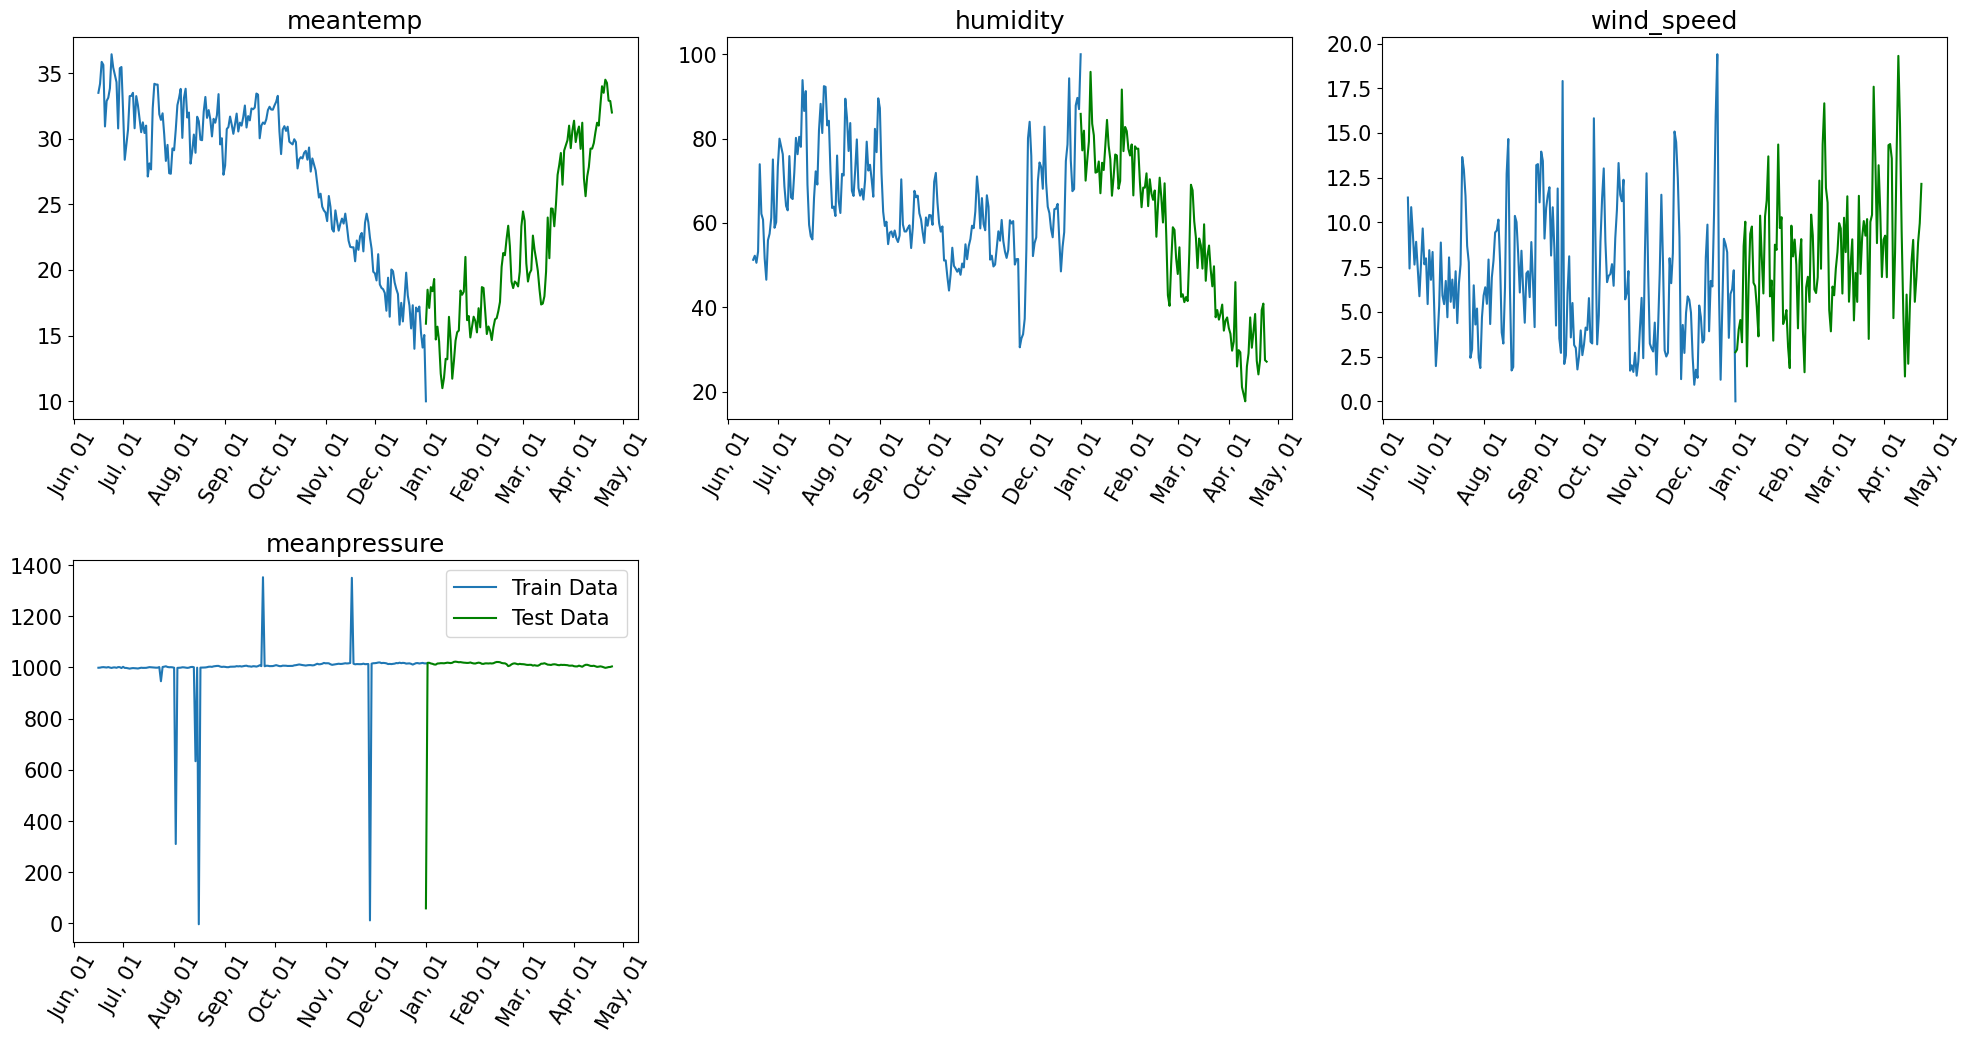

In [65]:
plt.figure(figsize=(20, 15))
date_formatter = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Assuming 'item_id' categorizes the data sufficiently for separate subplots
item_ids = df_long_train['item_id'].unique()

# Create subplots for each item_id
for idx, item_id in enumerate(item_ids):
    if idx >= 9:  # Limiting to first 9 plots for demonstration
        break
    ax = plt.subplot(3, 3, idx+1)

    # Select data by item_id
    ts_train = df_long_train[df_long_train['item_id'] == item_id]['target'].tail(200)
    ts_test = df_long_test[df_long_test['item_id'] == item_id]['target']

    # Plot training and test data
    plt.plot(ts_train.index, ts_train, label='Train Data')
    plt.plot(ts_test.index, ts_test, label='Test Data', color='g')

    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formatter)
    ax.set_title(item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [142]:
prediction_length = 90  # Define your prediction length.
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

context_length = 32

device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [143]:
last_date_train = df_long_train.index.max()
new_dates = pd.date_range(start=last_date_train + pd.Timedelta(days=1), periods=prediction_length)
unique_item_ids = df_long_train['item_id'].unique()
new_rows_list = []
for item_id in unique_item_ids:
  data = {
      'date': new_dates,
      'item_id': item_id,
      'target': [nan] * len(new_dates)
  }
  new_rows = pd.DataFrame(data)
  new_rows_list.append(new_rows)

new_rows_df = pd.concat(new_rows_list, ignore_index=True)
new_rows_df.set_index('date', inplace=True)
df_long_train_with_dummy_data = pd.concat([df_long_train, new_rows_df])

for col in df_long_train_with_dummy_data.columns:
  if df_long_train_with_dummy_data[col].dtype != "object" and pd.api.types.is_string_dtype(df_long_train_with_dummy_data[col]) == False:
    df_long_train_with_dummy_data[col] = df_long_train_with_dummy_data[col].astype("float32")


dataset['train_dummy'] = PandasDataset.from_long_dataframe(df_long_train_with_dummy_data, target="target", item_id="item_id")

<ipython-input-143-b46f4ef61bd8>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_long_train_with_dummy_data = pd.concat([df_long_train, new_rows_df])


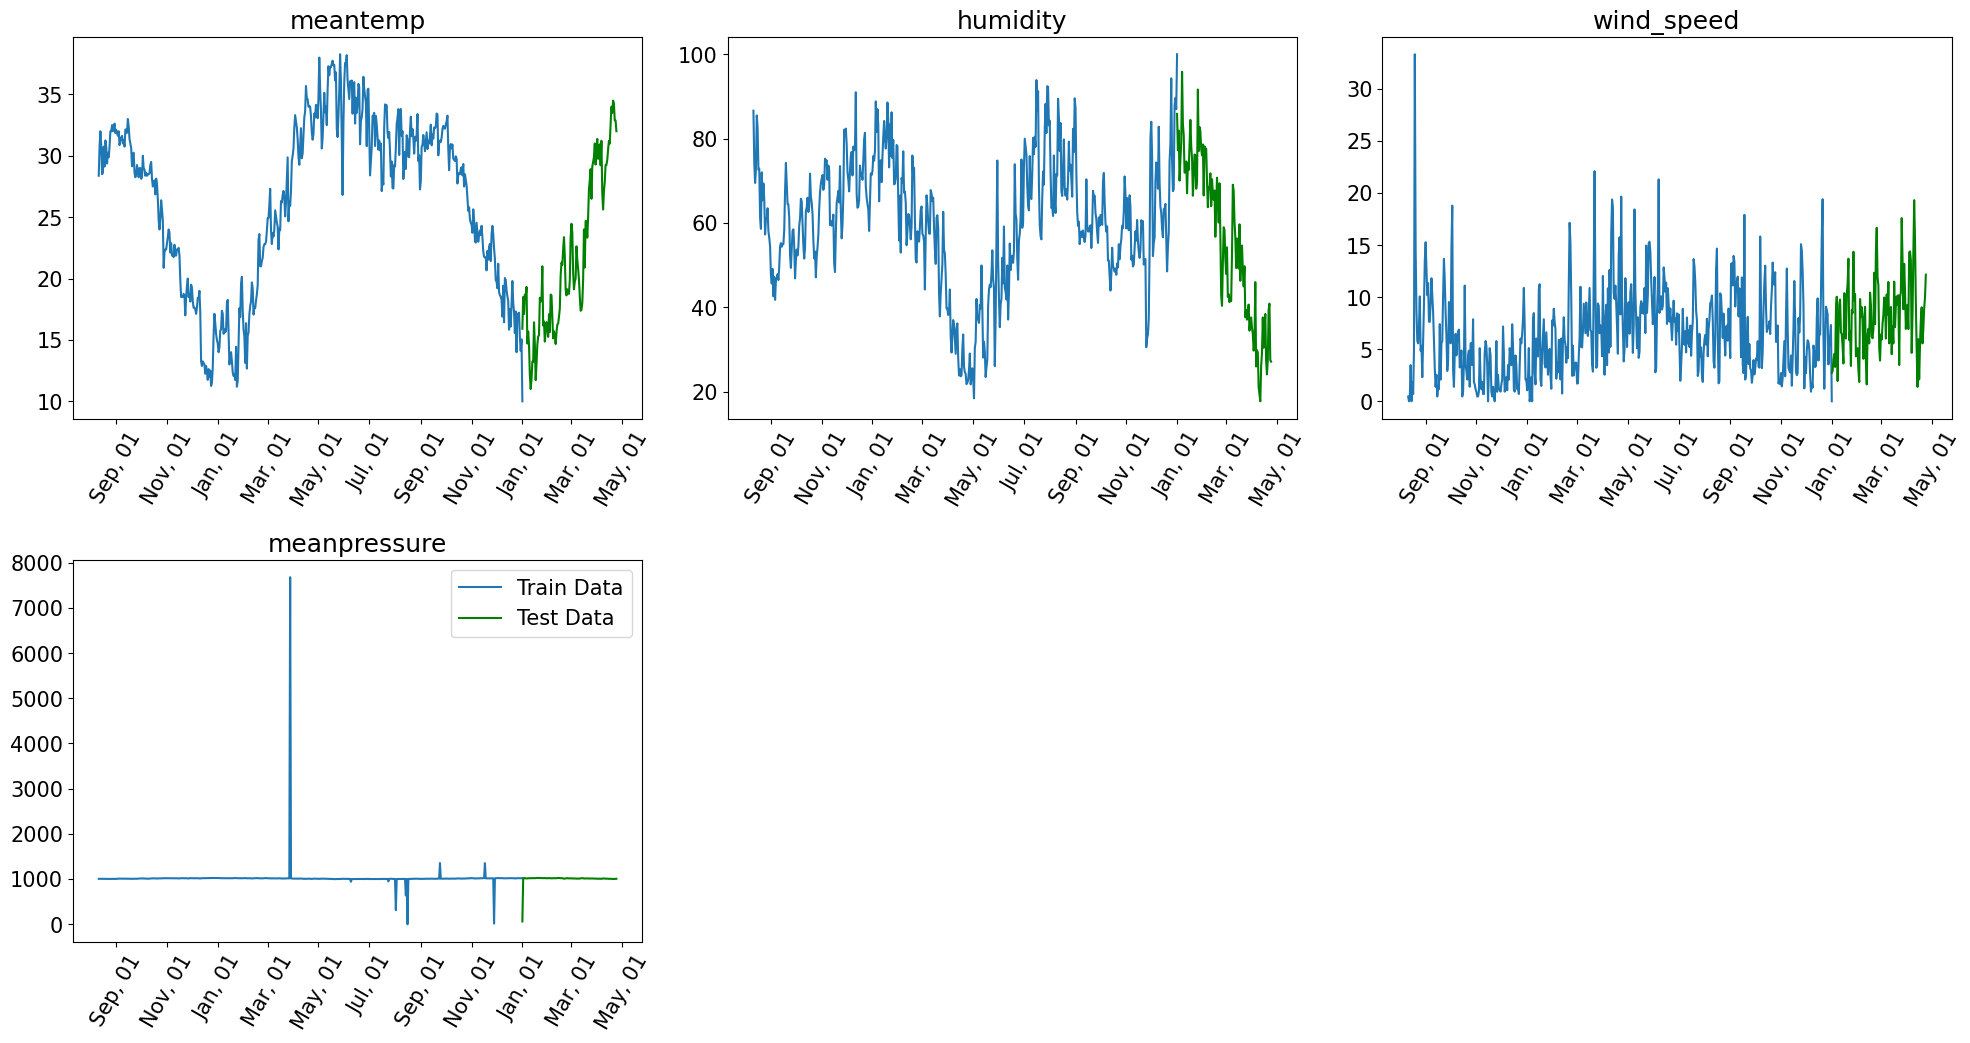

In [144]:
plt.figure(figsize=(20, 15))
date_formatter = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Assuming 'item_id' categorizes the data sufficiently for separate subplots
item_ids = df_long_train_with_dummy_data['item_id'].unique()

# Create subplots for each item_id
for idx, item_id in enumerate(item_ids):
    if idx >= 9:  # Limiting to first 9 plots for demonstration
        break
    ax = plt.subplot(3, 3, idx+1)

    # Select data by item_id
    ts_train = df_long_train_with_dummy_data[df_long_train_with_dummy_data['item_id'] == item_id]['target'].tail(600)
    ts_test = df_long_test[df_long_test['item_id'] == item_id]['target']

    # Plot training and test data
    plt.plot(ts_train.index, ts_train, label='Train Data')
    plt.plot(ts_test.index, ts_test, label='Test Data', color='g')

    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formatter)
    ax.set_title(item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [145]:
forecasts, tss = get_lag_llama_predictions(dataset['train_dummy'], prediction_length, context_length, num_samples, device)

Forecasting batches:   0%|          | 0/4 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/4 [00:00<?, ?it/s]

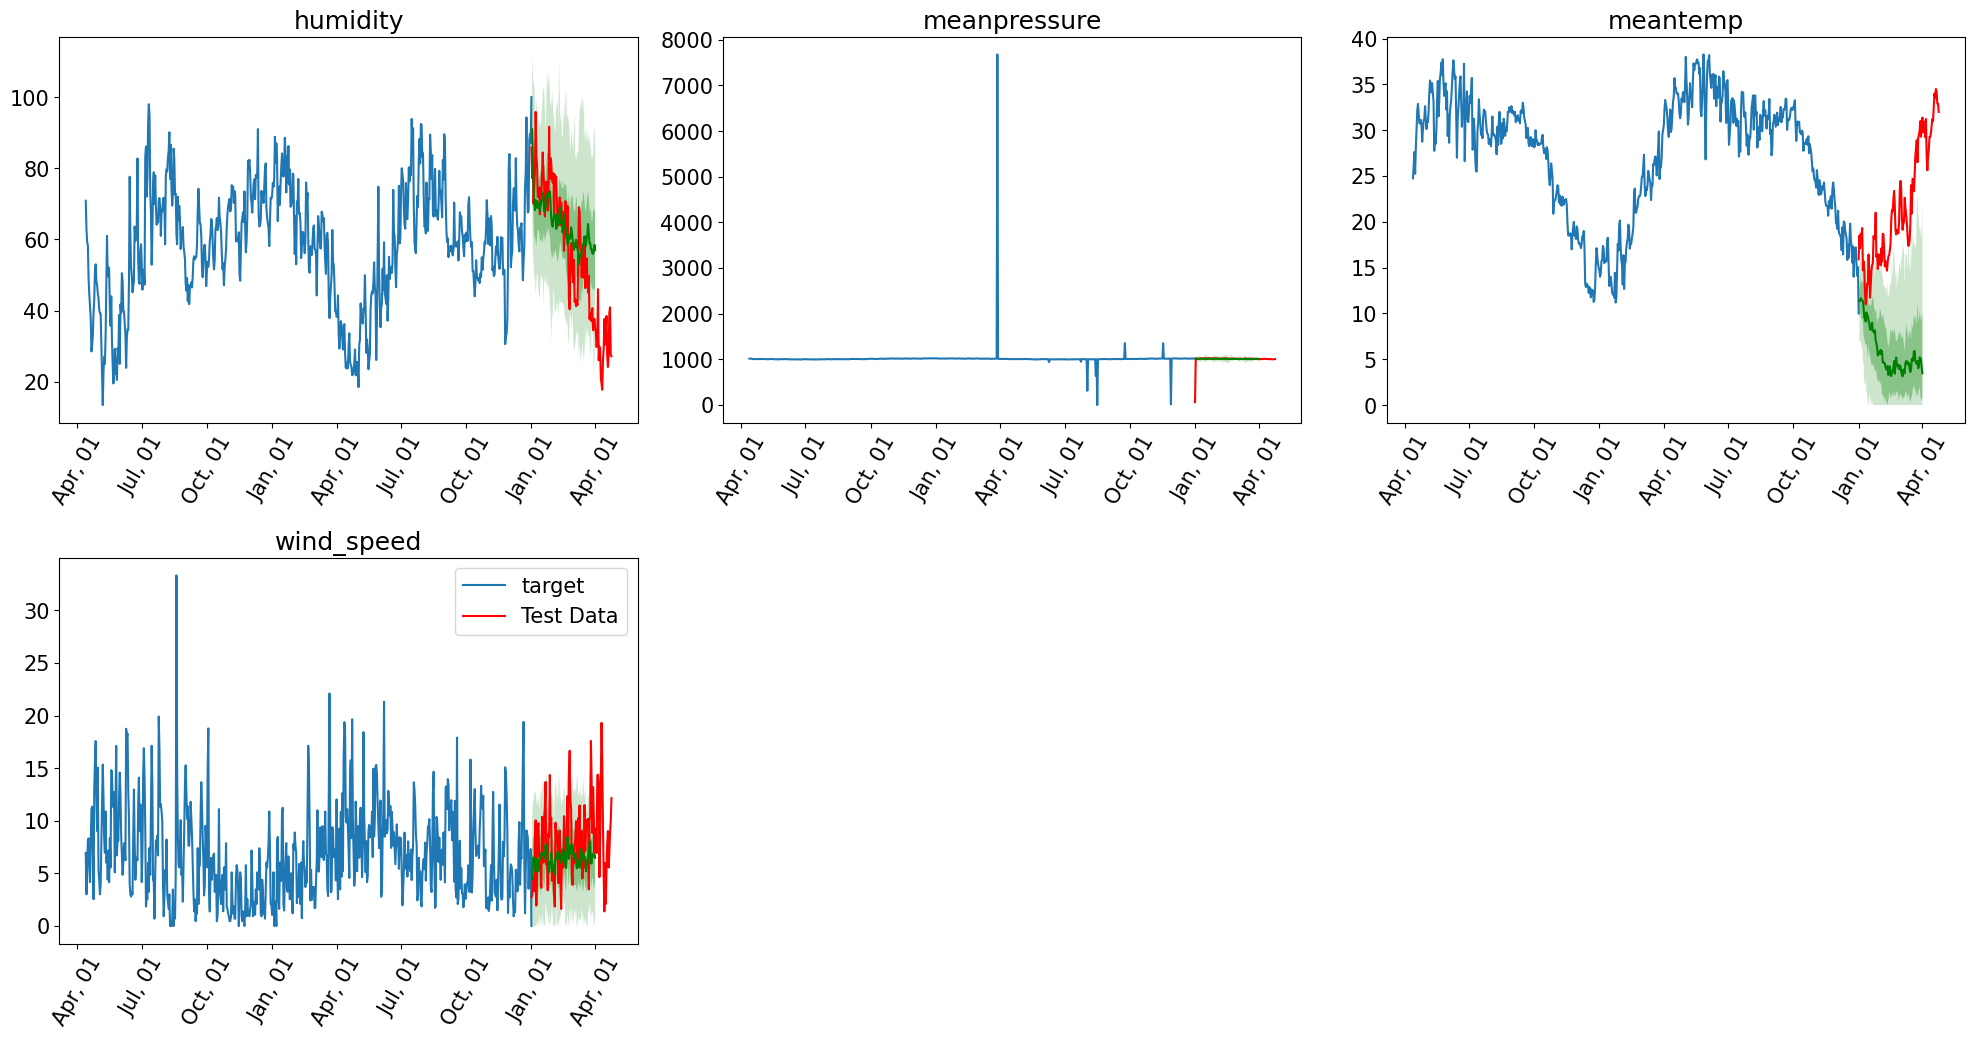

In [146]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-8 * prediction_length:].to_timestamp(), label="target", )
    ts_test = df_long_test[df_long_test['item_id'] == forecast.item_id]['target']

    plt.plot(ts_test.index, ts_test, label='Test Data', color='r')

    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()